# Imports

In [72]:
import pandas as pd
import numpy as np
import string
from matplotlib import pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from wordcloud import WordCloud

# Data Reading

In [73]:
data_frame = pd.read_csv("../Dataset/articles.csv")
data_frame.head()

# data_frame = data_frame.head(100)
data_frame["author"]

0                           Carl Hulse
1        Benjamin Mueller and Al Baker
2                         Margalit Fox
3                     William McDonald
4                        Choe Sang-Hun
                     ...              
49995                   Robinson Meyer
49996                       Amy Zegart
49997                    Jeremy Venook
49998                      Emily DeRuy
49999                     Marina Koren
Name: author, Length: 50000, dtype: object

# Data Cleaning
## 1- Handel Missing values
### a- Handel columns with missing values

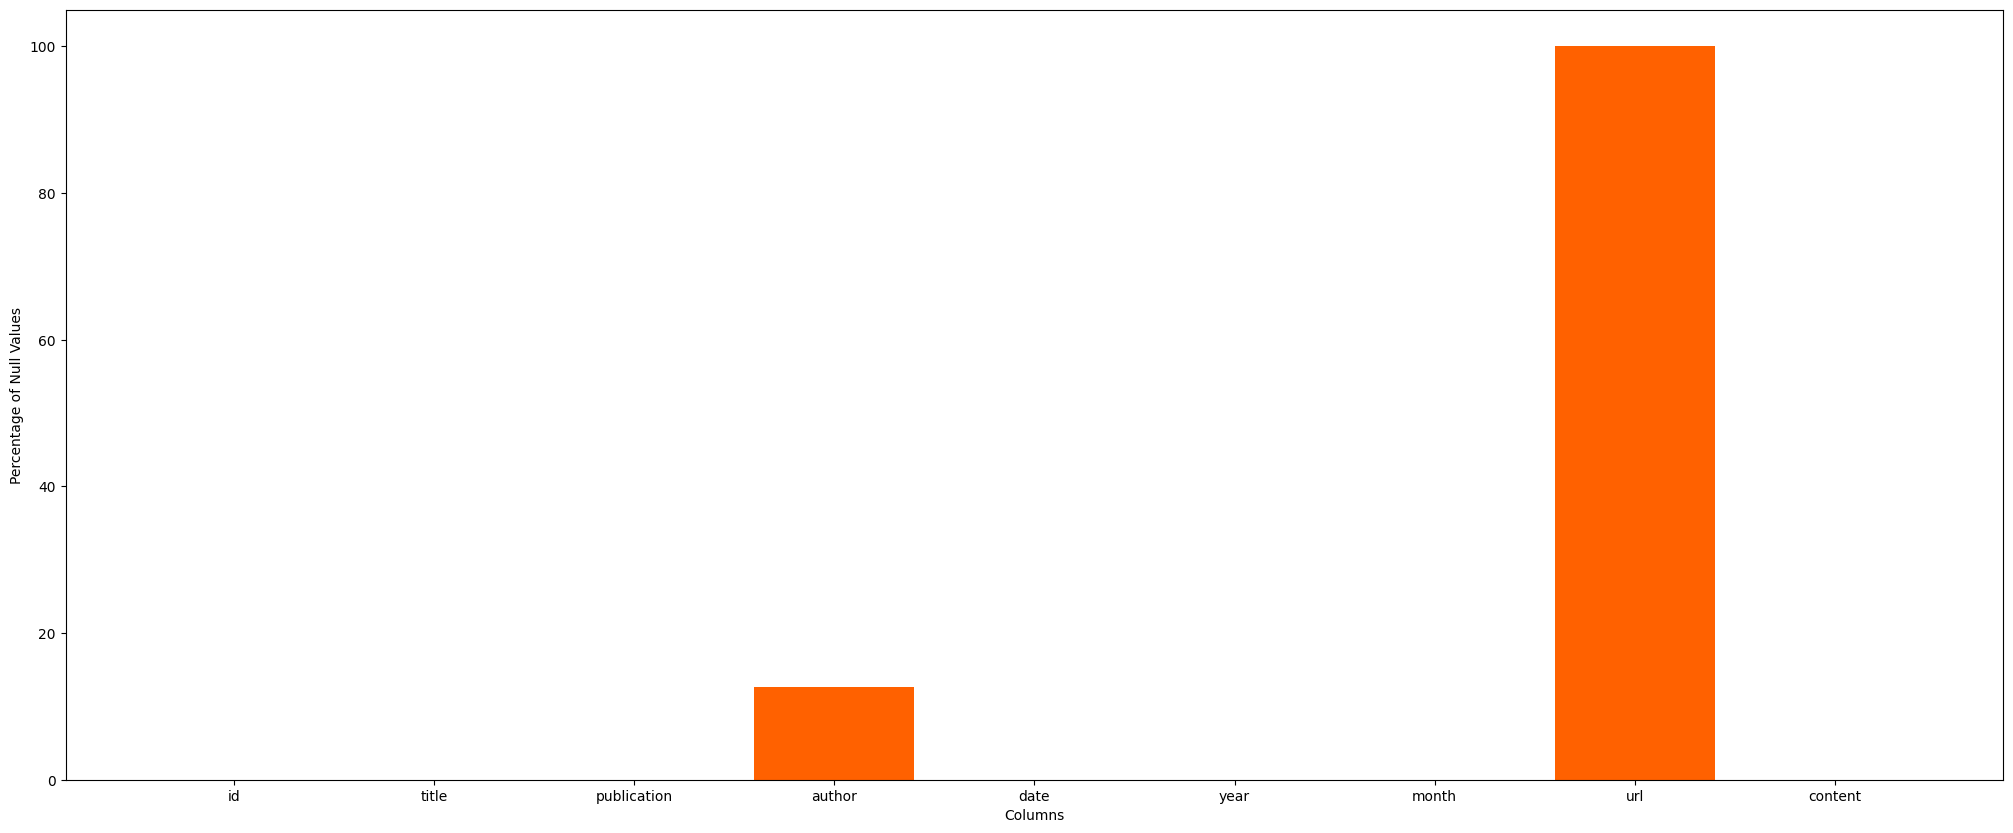

Unnamed: 0       0.000
id               0.000
title            0.000
publication      0.000
author          12.612
date             0.000
year             0.000
month            0.000
url            100.000
content          0.000
dtype: float64


In [74]:
# Get total number of nulls in each column
labels = data_frame.columns.tolist()
labels.pop(0)

data = (data_frame.isnull().sum() / len(data_frame) * 100).tolist()
data.pop(0)
# Creating plot
fig = plt.figure(figsize =(25, 10))
plt.bar(labels,data, color = "#FF6100")
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.show()
print(data_frame.isnull().sum() / len(data_frame) * 100)

In [75]:
# Remove url column because it's empty(100% null values)
data_frame.drop(columns=['url'], inplace=True)
data_frame.isnull().sum() / len(data_frame) * 100

Unnamed: 0      0.000
id              0.000
title           0.000
publication     0.000
author         12.612
date            0.000
year            0.000
month           0.000
content         0.000
dtype: float64

### b- Handel rows with missing values

In [76]:
# Get percentage of number of rows contain missing values
mask = data_frame.isnull().any(axis=1)
rows_with_missing_values = mask.sum() / len(data_frame)*100
print("Number of rows contain null values =", rows_with_missing_values, "%")

Number of rows contain null values = 12.612000000000002 %


In [77]:
# Drop rows contain null values
data_frame.dropna(inplace=True)
data_frame.isnull().sum() / len(data_frame) * 100

Unnamed: 0     0.0
id             0.0
title          0.0
publication    0.0
author         0.0
date           0.0
year           0.0
month          0.0
content        0.0
dtype: float64

## 2- Handel columns data types

In [78]:
data_frame.dtypes

Unnamed: 0       int64
id               int64
title           object
publication     object
author          object
date            object
year           float64
month          float64
content         object
dtype: object

In [79]:
data_frame= data_frame.astype({"title": "string",
                               "publication": "string",
                               "author": "string",
                               "date": "datetime64[ns]",
                               "year": "int64",
                               "month": "int64",
                               "content": "string"})

data_frame.dtypes

Unnamed: 0              int64
id                      int64
title          string[python]
publication    string[python]
author         string[python]
date           datetime64[ns]
year                    int64
month                   int64
content        string[python]
dtype: object

## 3- Dealing with unnecessary columns

In [80]:
# Drop id column because it contain unnecessary unique values
data_frame.drop(columns=['id'], inplace=True)
data_frame.head()

,Unnamed: 0,title,publication,author,date,year,month,content
0,0,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016,12,WASHINGTON — Congressional Republicans have...
1,1,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017,6,"After the bullet shells get counted, the blood..."
2,2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017,1,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017,4,"Death may be the great equalizer, but it isn’t..."
4,4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017,1,"SEOUL, South Korea — North Korea’s leader, ..."


In [81]:
# extract day from date column and rename column to day
data_frame['date'] = data_frame['date'].astype('string')
data_frame['date'] = data_frame['date'].str.replace("-", "/")
data_frame[["year", "month", "day"]] = data_frame["date"].str.split("/", expand = True)
data_frame['date'] = data_frame['day']
data_frame.drop(columns=["day"], inplace=True)
data_frame.rename(columns={"date": "day"}, inplace=True)
data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,31,2016,12,WASHINGTON — Congressional Republicans have...
1,1,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,19,2017,06,"After the bullet shells get counted, the blood..."
2,2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,06,2017,01,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,10,2017,04,"Death may be the great equalizer, but it isn’t..."
4,4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,02,2017,01,"SEOUL, South Korea — North Korea’s leader, ..."


# Text Preprocessing NLP Pipeline
## 1- Convert to lowercase

In [82]:
columns = ["title", "publication", "author", "content"]
for column in columns:
    data_frame[column] = data_frame[column].str.lower()

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,house republicans fret about winning their hea...,new york times,carl hulse,31,2016,12,washington — congressional republicans have...
1,1,rift between officers and residents as killing...,new york times,benjamin mueller and al baker,19,2017,06,"after the bullet shells get counted, the blood..."
2,2,"tyrus wong, ‘bambi’ artist thwarted by racial ...",new york times,margalit fox,06,2017,01,"when walt disney’s “bambi” opened in 1942, cri..."
3,3,"among deaths in 2016, a heavy toll in pop musi...",new york times,william mcdonald,10,2017,04,"death may be the great equalizer, but it isn’t..."
4,4,kim jong-un says north korea is preparing to t...,new york times,choe sang-hun,02,2017,01,"seoul, south korea — north korea’s leader, ..."


## 2- Remove HTML Tags

In [83]:
def remove_HTML_tags(text):
    return re.sub(r'<.*?>', "", text)

columns = ["title", "author", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_HTML_tags(x))

## 3- Remove URLs

In [84]:
def remove_URLs(text):
    return re.sub(r'https?://\S+www\.\S+', "", text)

columns = ["title", "author", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_URLs(x))

## 4- Remove Punctuations

In [85]:
punctuation = string.punctuation
def remove_punctuations(text):
    return text.translate(str.maketrans("", "", punctuation))

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_punctuations(x))

## 5- Remove Special Characters

In [86]:
columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].str.replace('[^a-zA-Z0-9]', " ", regex=True)

data_frame[['title', 'content']]

,title,content
0,house republicans fret about winning their hea...,washington congressional republicans have...
1,rift between officers and residents as killing...,after the bullet shells get counted the blood ...
2,tyrus wong bambi artist thwarted by racial b...,when walt disney s bambi opened in 1942 crit...
3,among deaths in 2016 a heavy toll in pop music...,death may be the great equalizer but it isn t ...
4,kim jongun says north korea is preparing to te...,seoul south korea north korea s leader ki...
...,...,...
49995,rex tillerson says climate change is real but,as chairman and ceo of exxonmobil rex tillerso...
49996,the biggest intelligence questions raised by t...,i ve spent nearly 20 years looking at intellig...
49997,trump announces plan that does little to resol...,donald trump will not be taking necessary st...
49998,dozens of forprofit colleges could soon close,dozens of colleges could be forced to close ...


## 6- Remove unnecessary spaces and words

In [87]:
# remove unnecessary spaces
columns = ["title", "author", "content"]
for column in columns:
    data_frame[column] = data_frame[column].str.replace('\s\s+', " ", regex=True)

data_frame[['title', 'content']]

,title,content
0,house republicans fret about winning their hea...,washington congressional republicans have a ne...
1,rift between officers and residents as killing...,after the bullet shells get counted the blood ...
2,tyrus wong bambi artist thwarted by racial bia...,when walt disney s bambi opened in 1942 critic...
3,among deaths in 2016 a heavy toll in pop music...,death may be the great equalizer but it isn t ...
4,kim jongun says north korea is preparing to te...,seoul south korea north korea s leader kim sai...
...,...,...
49995,rex tillerson says climate change is real but,as chairman and ceo of exxonmobil rex tillerso...
49996,the biggest intelligence questions raised by t...,i ve spent nearly 20 years looking at intellig...
49997,trump announces plan that does little to resol...,donald trump will not be taking necessary ste...
49998,dozens of forprofit colleges could soon close,dozens of colleges could be forced to close in...


In [88]:
# remove unnecessary words
# remove publication from title
publication_unique_values = data_frame["publication"].unique()
for publication in publication_unique_values:
    data_frame["title"] = data_frame['title'].str.replace("." + publication + "$", "", regex=True)

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,house republicans fret about winning their hea...,new york times,carl hulse,31,2016,12,washington congressional republicans have a ne...
1,1,rift between officers and residents as killing...,new york times,benjamin mueller and al baker,19,2017,06,after the bullet shells get counted the blood ...
2,2,tyrus wong bambi artist thwarted by racial bia...,new york times,margalit fox,06,2017,01,when walt disney s bambi opened in 1942 critic...
3,3,among deaths in 2016 a heavy toll in pop music...,new york times,william mcdonald,10,2017,04,death may be the great equalizer but it isn t ...
4,4,kim jongun says north korea is preparing to te...,new york times,choe sang-hun,02,2017,01,seoul south korea north korea s leader kim sai...


## 7- Apply Tokenization
### a- Apply sentence tokenization

In [89]:
# def sentence_tokenizer(text):
#     return sent_tokenize(text)
#
# columns = ["title", "content"]
# for column in columns:
#     data_frame[column] = data_frame[column].apply(lambda x: sentence_tokenizer(x))
#
# data_frame[['title', 'content']]

### b- Apply word tokenization

In [90]:
# def word_tokenizer(sentences):
#     tokenized_words = []
#     for x in sentences:
#         tokenized_words = tokenized_words + word_tokenize(x)
#     return tokenized_words

def word_tokenizer(text):
    return word_tokenize(text)
columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: word_tokenizer(x))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[house, republicans, fret, about, winning, the...",new york times,carl hulse,31,2016,12,"[washington, congressional, republicans, have,..."
1,1,"[rift, between, officers, and, residents, as, ...",new york times,benjamin mueller and al baker,19,2017,06,"[after, the, bullet, shells, get, counted, the..."
2,2,"[tyrus, wong, bambi, artist, thwarted, by, rac...",new york times,margalit fox,06,2017,01,"[when, walt, disney, s, bambi, opened, in, 194..."
3,3,"[among, deaths, in, 2016, a, heavy, toll, in, ...",new york times,william mcdonald,10,2017,04,"[death, may, be, the, great, equalizer, but, i..."
4,4,"[kim, jongun, says, north, korea, is, preparin...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, s, leader,..."


## 8- Remove Stop Words

In [91]:
STOPWORDS = set(stopwords.words("english"))
def remove_stop_words(text):
    return [word for word in text if word not in STOPWORDS]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_stop_words(x))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[house, republicans, fret, winning, health, ca...",new york times,carl hulse,31,2016,12,"[washington, congressional, republicans, new, ..."
1,1,"[rift, officers, residents, killings, persist,...",new york times,benjamin mueller and al baker,19,2017,06,"[bullet, shells, get, counted, blood, dries, v..."
2,2,"[tyrus, wong, bambi, artist, thwarted, racial,...",new york times,margalit fox,06,2017,01,"[walt, disney, bambi, opened, 1942, critics, p..."
3,3,"[among, deaths, 2016, heavy, toll, pop, music]",new york times,william mcdonald,10,2017,04,"[death, may, great, equalizer, necessarily, ev..."
4,4,"[kim, jongun, says, north, korea, preparing, t...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, leader, ki..."


## 9- Remove frequently words

In [92]:
word_counter_title = Counter()
word_counter_content = Counter()
def get_most_frequently_words(column_name, word_counter):
    for text in data_frame[column_name]:
        for word in text:
            word_counter[word] += 1
    return word_counter

# get the most common frequently words in [title] more than 1000
word_frequency_title = get_most_frequently_words("title", word_counter_title).most_common(10)

# get the most common frequently words in [content]
word_frequency_content = get_most_frequently_words("content", word_counter_content).most_common(10)

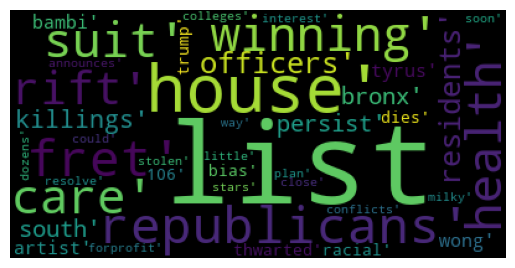

In [93]:
text = data_frame['title'].values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

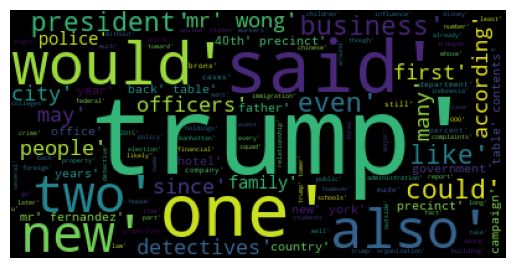

In [94]:
text = data_frame['content'].values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [95]:
FREQUENT_WORDS_TITLE = set(word for (word, word_count) in get_most_frequently_words("title", word_counter_title).most_common(10))
FREQUENT_WORDS_CONTENT = set(word for (word, word_count) in get_most_frequently_words("content", word_counter_content).most_common(10))

def remove_frequent_words(string_text, frequent_words):
    return [word for word in string_text if word not in frequent_words]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_frequent_words(x, FREQUENT_WORDS_TITLE))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[house, republicans, fret, winning, health, ca...",new york times,carl hulse,31,2016,12,"[washington, congressional, republicans, fear,..."
1,1,"[rift, officers, residents, killings, persist,...",new york times,benjamin mueller and al baker,19,2017,06,"[bullet, shells, get, counted, blood, dries, v..."
2,2,"[tyrus, wong, bambi, artist, thwarted, racial,...",new york times,margalit fox,06,2017,01,"[walt, disney, bambi, opened, 1942, critics, p..."
3,3,"[among, deaths, 2016, heavy, toll, pop, music]",new york times,william mcdonald,10,2017,04,"[death, may, great, equalizer, necessarily, ev..."
4,4,"[kim, jongun, north, korea, preparing, test, l...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, leader, ki..."


## 10- Remove rare words

In [96]:
RARE_WORDS_TITLE = set(word for (word, word_count) in get_most_frequently_words("title", word_counter_title).most_common()[:-10:-1])
RARE_WORDS_CONTENT = set(word for (word, word_count) in get_most_frequently_words("content", word_counter_content).most_common()[:-10:-1])

def remove_rare_words(string_text, rare_words):
    return [word for word in string_text if word not in rare_words]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_rare_words(x, RARE_WORDS_TITLE))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[house, republicans, fret, winning, health, ca...",new york times,carl hulse,31,2016,12,"[washington, congressional, republicans, fear,..."
1,1,"[rift, officers, residents, killings, persist,...",new york times,benjamin mueller and al baker,19,2017,06,"[bullet, shells, get, counted, blood, dries, v..."
2,2,"[tyrus, wong, bambi, artist, thwarted, racial,...",new york times,margalit fox,06,2017,01,"[walt, disney, bambi, opened, 1942, critics, p..."
3,3,"[among, deaths, 2016, heavy, toll, pop, music]",new york times,william mcdonald,10,2017,04,"[death, may, great, equalizer, necessarily, ev..."
4,4,"[kim, jongun, north, korea, preparing, test, l...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, leader, ki..."


## 11- Apply Stemming

In [97]:
porter_stemmer_title = PorterStemmer()
porter_stemmer_content = PorterStemmer()
def stemming_words(text, porter_stemmer):
    return [porter_stemmer.stem(word) for word in text]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: stemming_words(x, porter_stemmer_title))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[hous, republican, fret, win, health, care, suit]",new york times,carl hulse,31,2016,12,"[washington, congression, republican, fear, co..."
1,1,"[rift, offic, resid, kill, persist, south, bronx]",new york times,benjamin mueller and al baker,19,2017,06,"[bullet, shell, get, count, blood, dri, votiv,..."
2,2,"[tyru, wong, bambi, artist, thwart, racial, bi...",new york times,margalit fox,06,2017,01,"[walt, disney, bambi, open, 1942, critic, prai..."
3,3,"[among, death, 2016, heavi, toll, pop, music]",new york times,william mcdonald,10,2017,04,"[death, may, great, equal, necessarili, evenha..."
4,4,"[kim, jongun, north, korea, prepar, test, long...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, leader, ki..."


## 12- Apply POS and Lemmatization

In [98]:
lemmatizer_title = WordNetLemmatizer()
lemmatizer_content = WordNetLemmatizer()
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

def lemmatize_words(text, lemmatizer):
    # apply POS tagging
    pos_text = pos_tag(text)
    return [lemmatizer.lemmatize(word, wordnet_map.get(pos[0],  wordnet.NOUN)) for word, pos in pos_text]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: lemmatize_words(x, lemmatizer_title))

# Data Preprocessing
## 1- Dealing with categorical data (Nominal Data)
### a- Preprocess [ publication ]

In [99]:
# get number of unique values in publication column
publication_unique_values = data_frame["publication"].unique()
print("Publication unique values = ", len(publication_unique_values))

Publication unique values =  5


In [100]:
# apply one hot encoding in publication column
data_frame = pd.get_dummies(data=data_frame, columns=["publication"])
data_frame.dtypes

Unnamed: 0                               int64
title                                   object
author                                  object
day                             string[python]
year                            string[python]
month                           string[python]
content                                 object
publication_atlantic                      bool
publication_breitbart                     bool
publication_business insider              bool
publication_cnn                           bool
publication_new york times                bool
dtype: object

### b- Preprocess [ author ]

In [101]:
# clean author
def clean_name(name):
    name = name.strip() # remove spaces after and before string
    name = " ".join(name.split()) # remove extra spaces between words
    name = re.sub(r'^.\s|\s.$', "", name) # remove single character in beginning and end of string

    if len(name) > 1:
        return name

author_unique_values = Counter()
def get_unique_names(author_list):
    for name in author_list:
        if name!=None and len(name) > 1:
            author_unique_values[name] += 1 # get unique values

def preprocess_author(text):
    text = re.sub(r'[a-z]{1}\.|\(.*\)', "", text) # remove single character in beginning and end of string
    author_list = re.split('with|and|,|&', text)
    author_list = [clean_name(name) for name in author_list]

    # check if there is a None value
    if None in author_list:
        author_list.remove(None)

    get_unique_names(author_list)
    return author_list

data_frame["author"] = data_frame["author"].apply(lambda x: preprocess_author(x))
data_frame["author"]

0                        [carl hulse]
1        [benjamin mueller, al baker]
2                      [margalit fox]
3                  [william mcdonald]
4                     [choe sang-hun]
                     ...             
49995                [robinson meyer]
49996                    [amy zegart]
49997                 [jeremy venook]
49998                   [emily deruy]
49999                  [marina koren]
Name: author, Length: 43694, dtype: object

In [102]:
# get number of empty cells in author
result = data_frame['author'].apply(lambda x: isinstance(x, list) and len(x) == 0)
count = result.sum()

# Print the count
print("Number of empty cells is:",count)

Number of empty cells is: 1


In [103]:
# make empty cell = null
data_frame["author"] = data_frame["author"].apply(lambda y: np.nan if len(y)==0 else y)

# remove rows with NaN values
data_frame.dropna(inplace=True)

# get number of empty cells in author
result = data_frame['author'].apply(lambda x: isinstance(x, list) and len(x) == 0)
count = result.sum()

# Print the count
print("Number of empty cells is:",count)

Number of empty cells is: 0


In [104]:
#filtered author column to make each row contain only one author
def filtered_author(author_list):
    frequency = []
    for author in author_list:
        frequency.append(author_unique_values[author])

    # Find the minimum number in the list
    min_number_index = frequency.index(min(frequency))
    return author_list[min_number_index]

data_frame["author"] = data_frame["author"].apply(lambda x: filtered_author(x))

# data_frame["author"]

In [105]:
# apply mapping in author
mapping_author = {}
for index, author in enumerate(list(author_unique_values.keys())):
    mapping_author[author] = index

data_frame = data_frame.replace ({
    "author": mapping_author
})

print("Number of unique values =", len(author_unique_values))
data_frame["author"]

Number of unique values = 2351


0           0.0
1           1.0
2           3.0
3           4.0
4           5.0
          ...  
49995    2289.0
49996    2324.0
49997    2300.0
49998    2277.0
49999    2306.0
Name: author, Length: 43693, dtype: float64

# Feature Extraction
## ⚫ Apply TF-IDF

In [106]:
data_frame['content'] = data_frame["content"].apply(lambda x: " ".join(x))
# Split the content column into training and testing sets
X_train, X_test = train_test_split(data_frame['content'], test_size=0.2, random_state=42)

# Define a TfidfVectorizer to convert the text data into a numerical representation
TF_IDF = TfidfVectorizer(stop_words='english')

# Convert the training data into numerical representations
TF_IDF_features_train = TF_IDF.fit_transform(X_train)

# Perform k-means clustering on the training data
num_clusters = 10
km = KMeans(n_clusters=num_clusters, random_state=0)
km.fit(TF_IDF_features_train)

# Convert the testing data into numerical representations
TF_IDF_features_test = TF_IDF.transform(X_test)

# Predict the clusters for the testing data
y_pred = km.predict(TF_IDF_features_test)

# Print the top terms in each cluster
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = TF_IDF.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i+1}:")
    for j in order_centroids[i, :10]:
        print(f"  {terms[j]}")

C:\Users\noura\OneDrive\Documents\Python Scripts\NLP-Topic-Modeling-Classification\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1:
  korea
  north
  korean
  missil
  kim
  nuclear
  china
  south
  pyongyang
  test
Cluster 2:
  comey
  fbi
  russian
  investig
  russia
  intellig
  say
  email
  presid
  flynn
Cluster 3:
  cruz
  rubio
  poll
  percent
  ted
  republican
  voter
  candid
  deleg
  say
Cluster 4:
  islam
  attack
  say
  isi
  muslim
  syria
  terrorist
  israel
  terror
  syrian
Cluster 5:
  say
  republican
  democrat
  presid
  vote
  campaign
  parti
  elect
  peopl
  think
Cluster 6:
  mr
  say
  presid
  republican
  campaign
  democrat
  parti
  hous
  senat
  make
Cluster 7:
  compani
  say
  market
  china
  year
  tax
  busi
  billion
  percent
  million
Cluster 8:
  gun
  breitbart
  milo
  news
  yiannopoulo
  twitter
  hawkin
  awr
  amend
  siriusxm
Cluster 9:
  say
  peopl
  woman
  year
  time
  report
  like
  make
  twitter
  tell
Cluster 10:
  immigr
  border
  illeg
  migrant
  texa
  cartel
  refuge
  deport
  say
  mexico
